# Predict layout of simulated chess board

In [31]:
import fnmatch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.utils.data

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights
import torchvision.transforms.functional as Tf

from pydrake.perception import PointCloud

from generate_chess_data import ChessDataGen

import plotly.express as px
from plotly.graph_objs import Scatter
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objects as go

import trimesh

## Define Mask R-CNN

In [4]:
pieces = [
    'BB', # : 'Bishop_B.urdf',
    'BW', # : 'Bishop_W.urdf',

    'KB', # : 'King_B.urdf',
    'KW', # : 'King_W.urdf',

    'NB', # : 'Knight_B.urdf',
    'NW', # : 'Knight_W.urdf',

    'PB', # : 'Pawn_B.urdf',
    'PW', # : 'Pawn_W.urdf',

    'QB', # : 'Queen_B.urdf',
    'QW', # : 'Queen_W.urdf',

    'RB', # : 'Rook_B.urdf',
    'RW', # : 'Rook_W.urdf'
]

def get_piece_from_label(label):
    return pieces[label - 1]

# num_images = len(fnmatch.filter(os.listdir(dataset_path),'*.png'))
# def open_image(idx):
#     filename = os.path.join(dataset_path, f"board_{idx:05d}.png")
#     return Image.open(filename).convert("RGB")

# model_file = 'weights/L_chess_maskrcnn_model_ep_15.pt'
# model_file = 'weights/chess_maskrcnn_model_10p.pt'  # 10 pieces
# model_file = 'weights/chess_maskrcnn_model_rp.pt'  # random num pieces
model_file = 'weights/chess_maskrcnn_model_ror.pt'  # Higher angle and random orient

In [5]:
%%capture

# ^Hide cell output

def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(
        weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

num_classes = len(pieces)+1
model = get_instance_segmentation_model(num_classes)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device(
    'cpu')
model.load_state_dict(
    torch.load(model_file, map_location=device))
model.eval()

model.to(device)

In [33]:
import matplotlib.patches as patches
import random

def plot_prediction(img, prediction):
    thresh = 0.97
    img_np = np.array(img)
    fig, ax = plt.subplots(1, figsize=(12,9))
    ax.imshow(img_np)

    cmap = plt.get_cmap('tab20b')
    colors = [cmap(i) for i in np.linspace(0, 1, 60)]

    num_instances = prediction[0]['boxes'].shape[0]
    bbox_colors = random.sample(colors, num_instances)
    boxes = prediction[0]['boxes'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().detach().numpy()

    for i in range(num_instances):
        if scores[i] < thresh:
            continue
        color = bbox_colors[i]
        bb = boxes[i,:]
        bbox = patches.Rectangle((bb[0], bb[1]), bb[2]-bb[0], bb[3]-bb[1],
                linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)
        plt.text(bb[0], bb[1], s=get_piece_from_label(labels[i]), 
                color='white', verticalalignment='top',
                bbox={'color': color, 'pad': 0})
        plt.text(bb[0], bb[3], s=str(f'{scores[i]:.3}'), 
                color='white', verticalalignment='bottom',
                bbox={'color': color, 'pad': 0})
    plt.axis('off');

In [6]:
data_station = ChessDataGen()

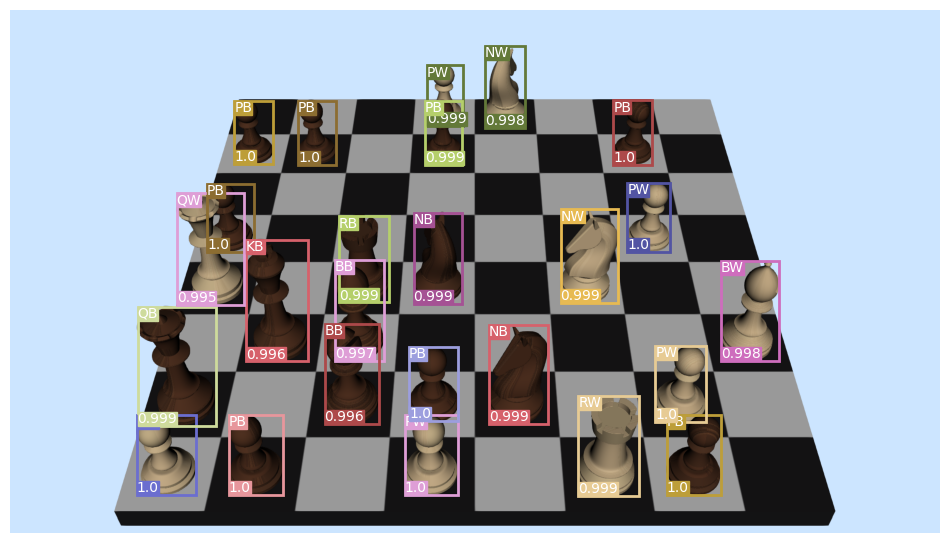

In [69]:
data_station.set_arbitrary_board(25)

color_image, depth_image, label_image = data_station.read_rgbd_sensor()

# Conver to rgb instead of rgba
color_image = Image.fromarray(np.uint8(color_image)).convert('RGB')

with torch.no_grad():
    prediction = model([Tf.to_tensor(color_image).to(device)])

plot_prediction(color_image, prediction)


In [62]:
labels = list(prediction[0]['labels'].cpu().detach().numpy())
scores = list(prediction[0]['scores'].cpu().detach().numpy()) 
thresh = 0.97

for i, label in enumerate(labels):
    if scores[i] < thresh:
        continue
    print(i, label, get_piece_from_label(label), scores[i])

0 7 PB 0.9998412
1 7 PB 0.9997999
2 8 PW 0.9997894
3 8 PW 0.9997842
4 7 PB 0.9997696
5 7 PB 0.9997476
6 7 PB 0.99970275
7 7 PB 0.9996669
8 8 PW 0.99957925
9 7 PB 0.9995301
10 8 PW 0.9995036
11 5 NB 0.9993017
12 11 RB 0.9991387
13 1 BB 0.99900997
14 5 NB 0.9988864
15 2 BW 0.9988147
16 11 RB 0.99846303
17 6 NW 0.9982095
18 12 RW 0.99791354
19 2 BW 0.9976236
20 6 NW 0.99731666
21 9 QB 0.9968092
22 4 KW 0.9947301
23 10 QW 0.9923096
24 8 PW 0.9815662


(31, 1, 1080, 1920)
<class 'numpy.ndarray'>


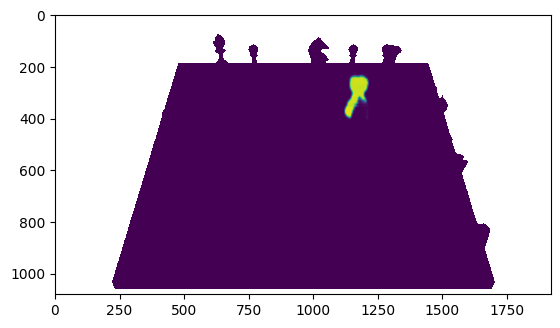

In [68]:

i = 16

masks = prediction[0]['masks'].cpu().detach().numpy()
print(masks.shape)

mask = masks[i].squeeze()
depth_image = depth_image.squeeze()

print(type(depth_image))
masked = depth_image*mask

plt.imshow(masked)

## Plot pointcloud generated

In [38]:
# https://stackoverflow.com/questions/41323423/plotly-inside-jupyter-notebook-python
init_notebook_mode(connected=True)         # initiate notebook for offline plot

point_cloud = data_station.station.GetOutputPort("camera_point_cloud").Eval(data_station.station_context)
print(point_cloud.size())
pcd_np = np.asarray(point_cloud.xyzs()).T
# print(pcd_np.shape)

pcd_np = pcd_np[~np.isinf(pcd_np).any(axis=1), :]
pcd_np = pcd_np[~np.isnan(pcd_np).any(axis=1), :]
print(pcd_np.shape)

n_samples = 50000
idxs = np.random.randint(0, len(pcd_np), (n_samples))
sample = pcd_np[idxs, :]


# pcd = trimesh.PointCloud(pcd_np)
# pcd_np = pcd.sam
# print(pcd_np.shape)

fig = px.scatter_3d()

fig.add_trace(go.Scatter3d(
    x=sample[:, 0], y=sample[:, 1], z=sample[:, 2],
    mode='markers', 
    marker=dict(color='rgba(255, 106, 100, 1.0)', size=1)
))

fig.update_layout(scene_aspectmode='data')


# trace0 = Scatter(
#   x=[1, 2, 3, 4],
#   y=[10, 15, 13, 17]
# )
# trace1 = Scatter(
#   x=[1, 2, 3, 4],
#   y=[16, 5, 11, 9]
# )

iplot(fig)

2073600
(1142024, 3)
